In [9]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import pickle

In [11]:
# Load Images
def load_images(data_path, img_size=(224, 224)):
    images = []
    labels = []
    train_path = os.path.join(data_path, r'C:\Users\mishr\Bone_Fracture_Binary_Classification\train')

    for label in ['fractured', 'not fractured']:
        label_path = os.path.join(train_path, label)

        if not os.path.exists(label_path):
            print(f"Directory not found: {label_path}")
            continue

        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Resize image to uniform size
                img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

                # Ensure 3 color channels
                if len(img_resized.shape) < 3:
                    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)

                images.append(img_resized)
                labels.append(1 if label == 'fractured' else 0)

    images = np.stack(images)
    labels = np.array(labels)

    print(f"Total images loaded: {len(images)}")
    print(f"Fractured images: {np.sum(labels)}")
    print(f"Non-fractured images: {len(labels) - np.sum(labels)}")

    return images, labels

In [13]:
# Preprocess Images
def preprocess_images(images):
    processed_images = []

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)
        gaussian = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(gaussian, 50, 150)
        processed_images.append(edges)

    return np.array(processed_images)

In [15]:
# Extract GLCM Features
def extract_glcm_features(processed_images):
    features = []

    for img in processed_images:
        glcm = graycomatrix(img, [1, 2, 3], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                            levels=256, symmetric=True, normed=True)
        props = [
            np.mean(graycoprops(glcm, prop))
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        ]
        features.append(props)

    return np.array(features)

In [17]:
# Train and Save Model
def train_and_save_model(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    svm = SVC(kernel='rbf', C=1.0, probability=True)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    voting_clf = VotingClassifier(estimators=[('svm', svm), ('rf', rf)], voting='soft')
    voting_clf.fit(X_train_scaled, y_train)
     # Save model and scaler
    with open('trained_classifier.pkl', 'wb') as model_file:
        pickle.dump(voting_clf, model_file)
    with open('scaler.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)

    print("Model and scaler saved successfully!")
    # Evaluate model
    y_pred = voting_clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    cv_scores = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5)
    print(f"Cross-validation Accuracy: {cv_scores.mean() * 100:.2f}% (+/- {cv_scores.std() * 2 * 100:.2f}%)")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [19]:
# Predict Single Image
def predict_single_image(image_path, img_size=(224, 224)):
    with open('trained_classifier.pkl', 'rb') as model_file:
        trained_classifier = pickle.load(model_file)
    with open('scaler.pkl', 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)

    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    gaussian = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gaussian, 50, 150)

    # Extract GLCM features
    glcm = graycomatrix(edges, [1, 2, 3], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    features = [
        np.mean(graycoprops(glcm, prop))
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    ]

    # Predict using the loaded model
    features_scaled = scaler.transform([features])
    prediction = trained_classifier.predict(features_scaled)

    plt.figure(figsize=(15, 5))
    plt.subplot(141), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(142), plt.imshow(gray, cmap='gray'), plt.title('Grayscale')
    plt.subplot(143), plt.imshow(gaussian, cmap='gray'), plt.title('Gaussian')
    plt.subplot(144), plt.imshow(edges, cmap='gray'), plt.title('Edges')
    plt.suptitle(f'Prediction: {"Fractured" if prediction[0] == 1 else "Not Fractured"}')
    plt.show()

    return "Fractured" if prediction[0] == 1 else "Not Fractured"

In [21]:
# Main Execution
def main():
    data_path = r"C:\Users\mishr\Bone_Fracture_Binary_Classification"

    # Load and preprocess data
    images, labels = load_images(data_path)
    processed_images = preprocess_images(images)
    features = extract_glcm_features(processed_images)

    # Train and save the model
    train_and_save_model(features, labels)

    # Test single image prediction
    test_image_path =r"C:\Users\mishr\OneDrive\Documents\Project CLG\Bone_fracture_detection\Bone_Fracture_Binary_Classification\Bone_Fracture_Binary_Classification\train\fractured\2d59fd50936098df8ddf49c912e70b_gallery (2).jpg"
    result = predict_single_image(test_image_path)
    print(f"Classification Result: {result}")

Total images loaded: 9140
Fractured images: 4527
Non-fractured images: 4613
Model and scaler saved successfully!
Accuracy: 93.71%
Cross-validation Accuracy: 89.18% (+/- 2.01%)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       919
           1       0.93      0.95      0.94       909

    accuracy                           0.94      1828
   macro avg       0.94      0.94      0.94      1828
weighted avg       0.94      0.94      0.94      1828



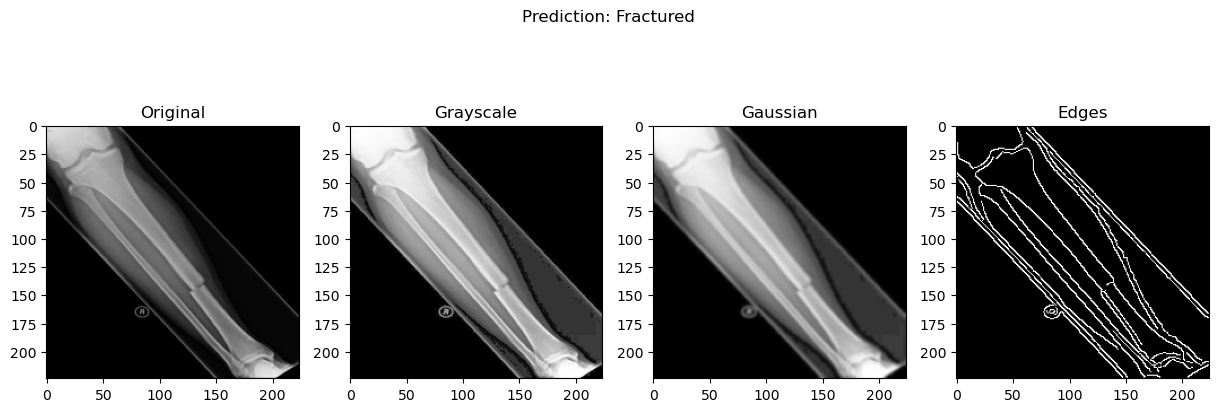

Classification Result: Fractured


In [23]:
if __name__ == "__main__":
    main()

Preprocessing time for this image: 0.8209 seconds


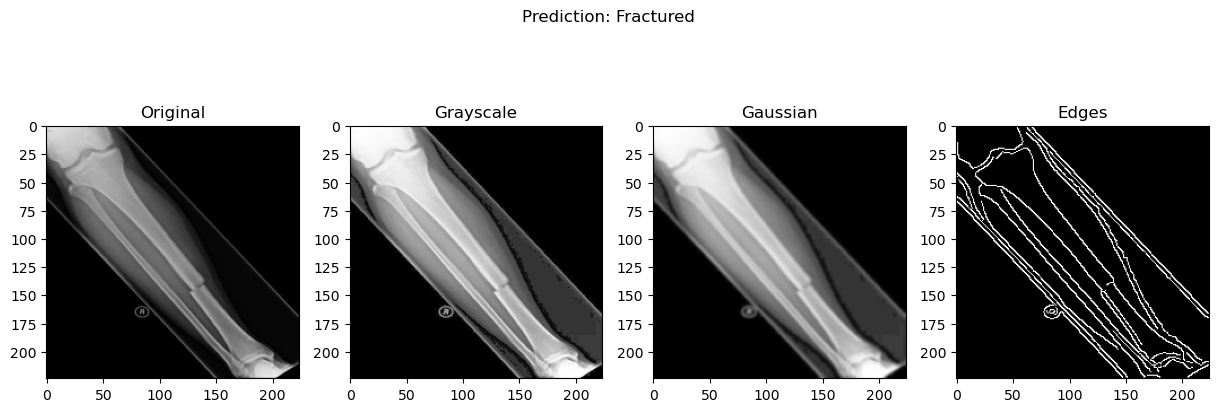

Classification Result: Fractured


In [27]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.feature import graycomatrix, graycoprops

# Predict Single Image
def predict_single_image(image_path, img_size=(224, 224)):
    # Load the trained model and scaler
    with open('trained_classifier.pkl', 'rb') as model_file:
        trained_classifier = pickle.load(model_file)
    with open('scaler.pkl', 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)

    # Read and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    
    start_time = time.time()  # Start timing

    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    gaussian = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gaussian, 50, 150)

    # Extract GLCM features
    glcm = graycomatrix(edges, [1, 2, 3], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    features = [
        np.mean(graycoprops(glcm, prop))
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    ]

    end_time = time.time()  # End timing
    preprocessing_time = end_time - start_time
    print(f"Preprocessing time for this image: {preprocessing_time:.4f} seconds")

    # Predict using the loaded model
    features_scaled = scaler.transform([features])
    prediction = trained_classifier.predict(features_scaled)

    # Display the image and prediction
    plt.figure(figsize=(15, 5))
    plt.subplot(141), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(142), plt.imshow(gray, cmap='gray'), plt.title('Grayscale')
    plt.subplot(143), plt.imshow(gaussian, cmap='gray'), plt.title('Gaussian')
    plt.subplot(144), plt.imshow(edges, cmap='gray'), plt.title('Edges')
    plt.suptitle(f'Prediction: {"Fractured" if prediction[0] == 1 else "Not Fractured"}')
    plt.show()

    return "Fractured" if prediction[0] == 1 else "Not Fractured"

# Main Execution
if __name__ == "__main__":
    # Update the path to the test image
    test_image_path = r"C:\Users\mishr\OneDrive\Documents\Project CLG\Bone_fracture_detection\Bone_Fracture_Binary_Classification\Bone_Fracture_Binary_Classification\train\fractured\2d59fd50936098df8ddf49c912e70b_gallery (2).jpg"
    try:
        result = predict_single_image(test_image_path)
        print(f"Classification Result: {result}")
    except Exception as e:
        print(f"Error: {e}")


Preprocessing time for this image: 0.7920 seconds


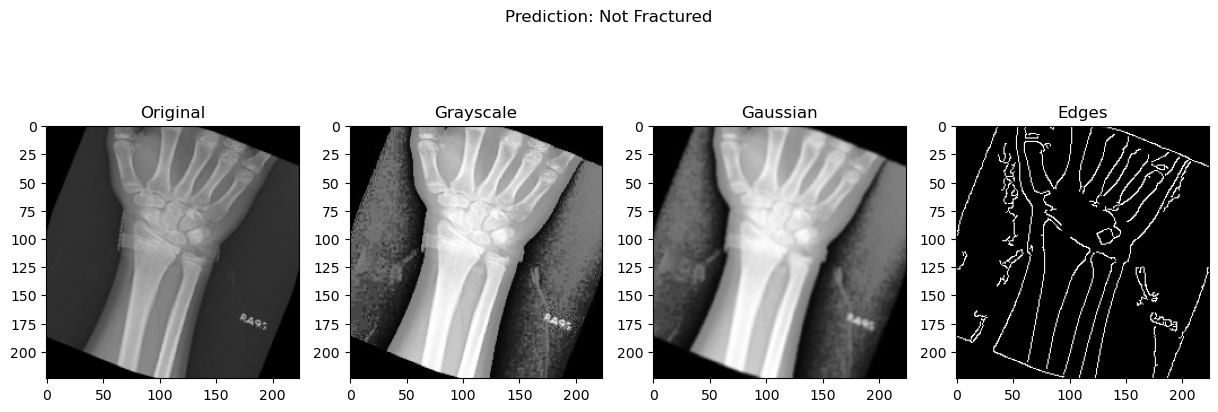

Classification Result: Not Fractured


In [33]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.feature import graycomatrix, graycoprops

# Predict Single Image
def predict_single_image(image_path, img_size=(224, 224)):
    # Load the trained model and scaler
    with open('trained_classifier.pkl', 'rb') as model_file:
        trained_classifier = pickle.load(model_file)
    with open('scaler.pkl', 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)

    # Read and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    
    start_time = time.time()  # Start timing

    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    gaussian = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gaussian, 50, 150)

    # Extract GLCM features
    glcm = graycomatrix(edges, [1, 2, 3], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    features = [
        np.mean(graycoprops(glcm, prop))
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    ]

    end_time = time.time()  # End timing
    preprocessing_time = end_time - start_time
    print(f"Preprocessing time for this image: {preprocessing_time:.4f} seconds")

    # Predict using the loaded model
    features_scaled = scaler.transform([features])
    prediction = trained_classifier.predict(features_scaled)

    # Display the image and prediction
    plt.figure(figsize=(15, 5))
    plt.subplot(141), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(142), plt.imshow(gray, cmap='gray'), plt.title('Grayscale')
    plt.subplot(143), plt.imshow(gaussian, cmap='gray'), plt.title('Gaussian')
    plt.subplot(144), plt.imshow(edges, cmap='gray'), plt.title('Edges')
    plt.suptitle(f'Prediction: {"Fractured" if prediction[0] == 1 else "Not Fractured"}')
    plt.show()

    return "Fractured" if prediction[0] == 1 else "Not Fractured"

# Main Execution
if __name__ == "__main__":
    # Update the path to the test image
    test_image_path = r"C:\Users\mishr\OneDrive\Documents\Project CLG\Bone_fracture_detection\Bone_Fracture_Binary_Classification\Bone_Fracture_Binary_Classification\test\not fractured\29-rotated1-rotated1-rotated3.jpg"
    try:
        result = predict_single_image(test_image_path)
        print(f"Classification Result: {result}")
    except Exception as e:
        print(f"Error: {e}")
